<center>

![huawei-logo](https://www-file.huawei.com/-/media/corporate/images/home/logo/huawei_logo.png)

<p><b>Летняя школа. "Современные методы теории информации, оптимизации и управления".</p></b>
Sirius-2020.
<center> <b>Авторы материала: к.т.н. Антонов Лев, Власов Роман.

## Применение AutoKeras к задаче DPD

In [1]:
!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1  &> /dev/null
!pip install autokeras  &> /dev/null
!git clone https://gitlab.com/spbroma/pyplot_lib.git  &> /dev/null

In [22]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
import tensorflow as tf
import autokeras as ak
import matplotlib.pyplot as plt

In [ ]:
# Import signal from Google Drive

#import scipy.io
#import subprocess
#import os

#from google.colab import drive
#drive.mount('/content/drive')
# import signal
#mat = scipy.io.loadmat('/content/drive/My Drive/Colab Notebooks/datasets/BlackBoxData_80.mat')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Import signal from github

import scipy.io
import subprocess
import os
# import signal
#mat = scipy.io.loadmat('/content/drive/My Drive/Colab Notebooks/datasets/BlackBoxData_80.mat')

# raw=true is important so you download the file rather than the webpage.
!wget https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData/blob/master/BlackBoxData_80.mat?raw=true
# rename the file
!mv BlackBoxData_80.mat\?raw\=true BlackBoxData_80.mat
# update scipy
#!pip install -U -q scipy
# Load the data
mat = scipy.io.loadmat('BlackBoxData_80.mat')

--2020-08-13 09:10:03--  https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData/blob/master/BlackBoxData_80.mat?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData/raw/master/BlackBoxData_80.mat [following]
--2020-08-13 09:10:03--  https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData/raw/master/BlackBoxData_80.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Huawei-Sirius-Summer-2020/BlackBoxData/master/BlackBoxData_80.mat [following]
--2020-08-13 09:10:03--  https://raw.githubusercontent.com/Huawei-Sirius-Summer-2020/BlackBoxData/master/BlackBoxData_80.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.

Первое представление наших данных, которые мы попробуем - это простое разбиение сигнала (вектора комплексных чисел) на реальную и мнимую части.

[![5-1-data-format.png](https://i.postimg.cc/yNqsKJg5/5-1-data-format.png)](https://postimg.cc/DSctdwcd)

In [23]:
x = (mat['x'] * (2 ** -15)).reshape(-1, 1)
y = (mat['y'] * (2 ** -15)).reshape(-1, 1)

X = np.concatenate((np.real(x), np.imag(x)), axis=1)
Y = np.concatenate((np.real(y), np.imag(y)), axis=1)

s = int(X.shape[0] * 0.9)
#x_train = pd.DataFrame(X[:s]); x_val = pd.DataFrame(X[s:])
#y_train = pd.DataFrame(Y[:s]); y_val = pd.DataFrame(Y[s:])

x_train = X[:s]; x_val = X[s:]
y_train = Y[:s]; y_val = Y[s:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((89856, 2), (89856, 2), (9984, 2), (9984, 2))

Теперь паре чисел входного сигнала соответствует пара чисел выходного.

In [ ]:
print("{} {:>25}".format('X', 'Y'))
for i in np.arange(5):
  print(x_train[i], x_train[i])

X                         Y
[ 0.00238037 -0.01348877] [ 0.00238037 -0.01348877]
[-0.00765991 -0.01791382] [-0.00765991 -0.01791382]
[-0.01525879 -0.01779175] [-0.01525879 -0.01779175]
[-0.01824951 -0.01293945] [-0.01824951 -0.01293945]
[-0.01608276 -0.00430298] [-0.01608276 -0.00430298]


#### Эксперимент №1
Передадим эту выборку (предварительно разделенную на train и validation) в блок **StructuredDataRegressor** установим **max_trials=1**, **epochs=10** и зафиксируем seed, чтобы просто прикинуть работает ли данный подход.

In [ ]:
OUTPUT_PATH = '5_AutoML_Regression_pdp'

# Initialize the structured data regressor.
reg = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials=1,
    directory  = OUTPUT_PATH,
    seed = 123) 

reg.fit(x_train,
        y_train,
        # Use your own validation set.
        validation_data=(x_val, y_val),
        epochs=10)

Trial 1 Complete [00h 00m 37s]
val_loss: 0.0001472731091780588

Best val_loss So Far: 0.0001472731091780588
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
2808/2808 [==============================] - 4s 1ms/step - loss: 1.7868e-04 - mean_squared_error: 1.7868e-04 - val_loss: 1.7325e-04 - val_mean_squared_error: 1.7325e-04
Epoch 2/10
2808/2808 [==============================] - 4s 1ms/step - loss: 1.5580e-04 - mean_squared_error: 1.5580e-04 - val_loss: 1.6263e-04 - val_mean_squared_error: 1.6263e-04
Epoch 3/10
2808/2808 [==============================] - 4s 1ms/step - loss: 1.5313e-04 - mean_squared_error: 1.5313e-04 - val_loss: 1.5705e-04 - val_mean_squared_error: 1.5705e-04
Epoch 4/10
2808/2808 [==============================] - 4s 1ms/step - loss: 1.5128e-04 - mean_squared_error: 1.5128e-04 - val_loss: 1.5423e-04 - val_mean_squared_error: 1.5423e-04
Epoch 5/10
2808/2808 [==============================] - 4s 1ms/step - loss: 1.5010e-04 - mean_squared_

In [ ]:
model = reg.export_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 256)               768       
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 2)                 514       
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


Предсказываем значение ***y*** на валидации, превращаем реальное представление данных в комплексное и считаем **nmse** в децибелах.

In [ ]:
y_ = reg.predict(x_val)

In [ ]:
y_pred_cmpx = np.vectorize(complex)(y_[:,0]   , y_[:,1])
y_val_cmpx  = np.vectorize(complex)(y_val[:,0], y_val[:,1])
x_val_cmpx  = np.vectorize(complex)(x_val[:,0], x_val[:,1])

In [ ]:
ex = x_val_cmpx * np.conj(x_val_cmpx)
ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
nmse

(-23.440443412471318+0j)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


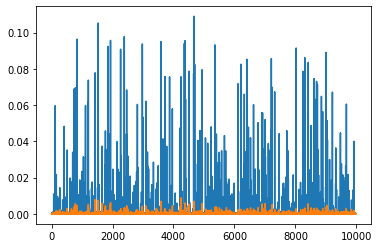

In [ ]:
plt.plot(y_val_cmpx * np.conj(y_val_cmpx))
plt.plot(ee)

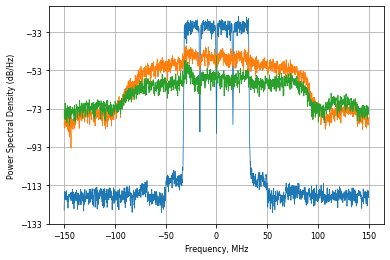

In [ ]:
from pyplot_lib.plot_lib import plot_psd
plot_psd([x_val_cmpx, y_val_cmpx, y_val_cmpx - y_pred_cmpx])
# df = pd.DataFrame({'x': x_val_cmpx, 'd': y_val_cmpx, 'error': ee})
# write_data_to_csv(df, 'input_data_train')

#### Эксперимент №2
Первая симуляция дала некоторый положительный результат (пускай и очень слабый). Поэтому, попробуем увелиличь время симулции и количество исследуемых моделей и посмотрим, как изменится результат.
**max_trials=5, epochs=30**

In [ ]:
OUTPUT_PATH = '5_AutoML_Regression_pdp_5'

# Initialize the structured data regressor.
reg_5 = ak.StructuredDataRegressor(
    overwrite = True,
    max_trials = 5,
    directory  = OUTPUT_PATH,
    seed = 123) # It tries 10 different models.

In [ ]:
reg_5.fit(x_train,
        y_train,
        # Use your own validation set.
        validation_data=(x_val, y_val),
        epochs=30)

Trial 5 Complete [00h 01m 15s]
val_loss: 0.00019289979536551982

Best val_loss So Far: 0.00014382896188180894
Total elapsed time: 00h 07m 37s
INFO:tensorflow:Oracle triggered exit
Epoch 1/30
2808/2808 [==============================] - 4s 1ms/step - loss: 1.7813e-04 - mean_squared_error: 1.7813e-04 - val_loss: 1.7056e-04 - val_mean_squared_error: 1.7056e-04
Epoch 2/30
2808/2808 [==============================] - 4s 1ms/step - loss: 1.5618e-04 - mean_squared_error: 1.5618e-04 - val_loss: 1.6194e-04 - val_mean_squared_error: 1.6194e-04
Epoch 3/30
2808/2808 [==============================] - 4s 1ms/step - loss: 1.5337e-04 - mean_squared_error: 1.5337e-04 - val_loss: 1.5804e-04 - val_mean_squared_error: 1.5804e-04
Epoch 4/30
2808/2808 [==============================] - 4s 1ms/step - loss: 1.5174e-04 - mean_squared_error: 1.5174e-04 - val_loss: 1.5392e-04 - val_mean_squared_error: 1.5392e-04
Epoch 5/30
2808/2808 [==============================] - 4s 1ms/step - loss: 1.5051e-04 - mean_square

In [ ]:
model_5 = reg_5.export_model()
model_5.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 256)               768       
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 2)                 514       
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_ = reg_5.predict(x_val)

In [ ]:
y_pred_cmpx = np.vectorize(complex)(y_[:,0]   , y_[:,1])
y_val_cmpx  = np.vectorize(complex)(y_val[:,0], y_val[:,1])
x_val_cmpx  = np.vectorize(complex)(x_val[:,0], x_val[:,1])

In [ ]:
ex = x_val_cmpx * np.conj(x_val_cmpx)
ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
nmse

(-23.51947283819402+0j)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


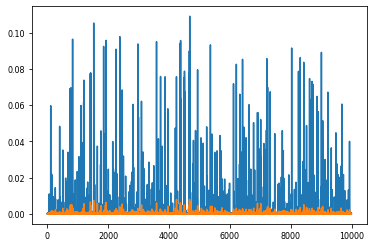

In [ ]:
plt.plot(y_val_cmpx * np.conj(y_val_cmpx))
plt.plot(ee)

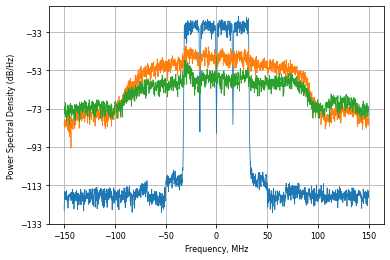

In [ ]:
plot_psd([x_val_cmpx, y_val_cmpx, y_val_cmpx - y_pred_cmpx])

In [ ]:
# результаты на трейне
y_full = reg_5.predict(x_train)

In [ ]:
y_pred__train_cmpx = np.vectorize(complex)(y_full[:,0]   , y_full[:,1])
y_train_cmpx  = np.vectorize(complex)(y_train[:,0], y_train[:,1])
x_train_cmpx  = np.vectorize(complex)(x_train[:,0], x_train[:,1])

In [ ]:
ex = x_train_cmpx * np.conj(x_train_cmpx)
ee = (y_train_cmpx - y_pred__train_cmpx) * np.conj(y_train_cmpx - y_pred__train_cmpx)
nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
nmse

(-23.54646020871143+0j)

In [ ]:
ex = x_val_cmpx * np.conj(x_val_cmpx)
ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
nmse

(-23.51947283819402+0j)

Результат получился практически такой же, как и после единичного прогона

#### Симуляция 3
Что бы убедиться в факте того, что увеличение времени ожидания не приносит существенного улучшения перформанса, увеличим еще больше параметры **max_trials и epochs**.


In [ ]:
OUTPUT_PATH = '5_AutoML_Regression_pdp_30'

# Initialize the structured data regressor.
reg_5 = ak.StructuredDataRegressor(
    overwrite = True,
    max_trials = 50,
    directory  = OUTPUT_PATH,
    seed = 123) # It tries 10 different models.

In [ ]:
reg_5.fit(x_train,
        y_train,
        # Use your own validation set.
        validation_data=(x_val, y_val),
        epochs=30)

Trial 50 Complete [00h 14m 32s]
val_loss: 0.00038449387648142874

Best val_loss So Far: 0.00013813484110869467
Total elapsed time: 02h 39m 58s
INFO:tensorflow:Oracle triggered exit
Epoch 1/30
2808/2808 [==============================] - 5s 2ms/step - loss: 7.7577e-04 - mean_squared_error: 7.7577e-04 - val_loss: 5.6188e-04 - val_mean_squared_error: 5.6188e-04
Epoch 2/30
2808/2808 [==============================] - 5s 2ms/step - loss: 4.3193e-04 - mean_squared_error: 4.3193e-04 - val_loss: 3.5178e-04 - val_mean_squared_error: 3.5178e-04
Epoch 3/30
2808/2808 [==============================] - 5s 2ms/step - loss: 2.8718e-04 - mean_squared_error: 2.8718e-04 - val_loss: 2.5066e-04 - val_mean_squared_error: 2.5066e-04
Epoch 4/30
2808/2808 [==============================] - 5s 2ms/step - loss: 2.1492e-04 - mean_squared_error: 2.1492e-04 - val_loss: 1.9794e-04 - val_mean_squared_error: 1.9794e-04
Epoch 5/30
2808/2808 [==============================] - 5s 2ms/step - loss: 1.7738e-04 - mean_squar

In [ ]:
model = reg_5.export_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33792     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 2)                

In [ ]:
y_ = reg_5.predict(x_val)

In [ ]:
y_pred_cmpx = np.vectorize(complex)(y_[:,0]   , y_[:,1])
y_val_cmpx  = np.vectorize(complex)(y_val[:,0], y_val[:,1])
x_val_cmpx  = np.vectorize(complex)(x_val[:,0], x_val[:,1])

In [ ]:
ex = x_val_cmpx * np.conj(x_val_cmpx)
ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
nmse

(-23.723833221579383+0j)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


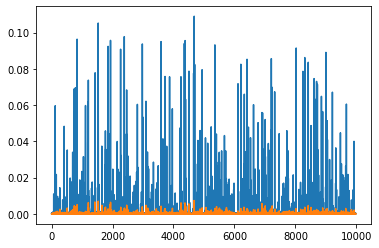

In [ ]:
plt.plot(y_val_cmpx * np.conj(y_val_cmpx))
plt.plot(ee)

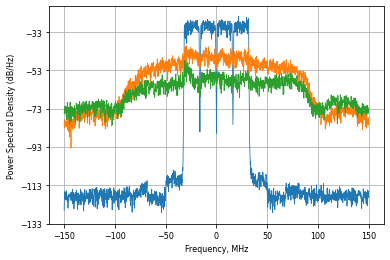

In [ ]:
from pyplot_lib.plot_lib import plot_psd
plot_psd([x_val_cmpx, y_val_cmpx, y_val_cmpx - y_pred_cmpx])

Резюмируем результаты и затраченное время на симуляции:

| Значение параметров        | Результаты (nmse/dbs) |Время архитектурного поиска|
| :-------------------------  | ---------------------- | --------- |
| max_trials = 1, epochs = 10 | -23.44                 |00h 00m 37s|
| max_trials = 5, epochs = 30 | -23.51                 |00h 07m 37s|
| max_trials = 50, epochs = 30| **-23.71**             |**02h 39m 58s**|